# Semantic Search using Sentence Transformers

Semantic search seeks to improve search accuracy by understanding the content of the search query. In contrast to traditional search engines, which only find documents based on lexical matches, semantic search can also find synonyms.

The idea behind semantic search is to embed all entries in your corpus, whether they be sentences, paragraphs, or documents, into a vector space.

At search time, the query is embedded into the same vector space and the closest embeddings from your corpus are found. These entries should have a high semantic overlap with the query.

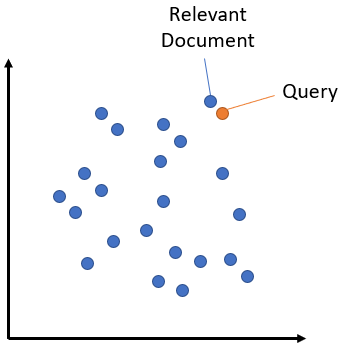

## Symmetric vs. Asymmetric Semantic Search
A critical distinction for your setup is symmetric vs. asymmetric semantic search:

- For **symmetric semantic search** your query and the entries in your corpus are of about the same length and have the same amount of content. An example would be searching for similar questions: Your query could for example be “How to learn Python online?” and you want to find an entry like “How to learn Python on the web?”. For symmetric tasks, you could potentially flip the query and the entries in your corpus.

- For **asymmetric semantic search**, you usually have a short query (like a question or some keywords) and you want to find a longer paragraph answering the query. An example would be a query like “What is Python” and you wand to find the paragraph “Python is an interpreted, high-level and general-purpose programming language. Python’s design philosophy …”. For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.

In this example we will be using **asymmetric semantic search**

## Github functions search engine

This is a step by step explanation to leverage the power of embeddings and semantic search to build a search engine based on Github's repositories

we will embed a dataset scrapped from github that contains various functions and methods and its corresponding metadata.


*Sentence Transformers* library provides us with abstractions that allow us to easily embed text and perform semantic search on it. without worrying about the underlying model.Tokenization etc. Although it is possible to opt out of this library and implement all the steps with its core libraries like Torch and numpy we will stick to the library for the sake of simplicity.

a basic schema representation of what we are goign to build is the following:
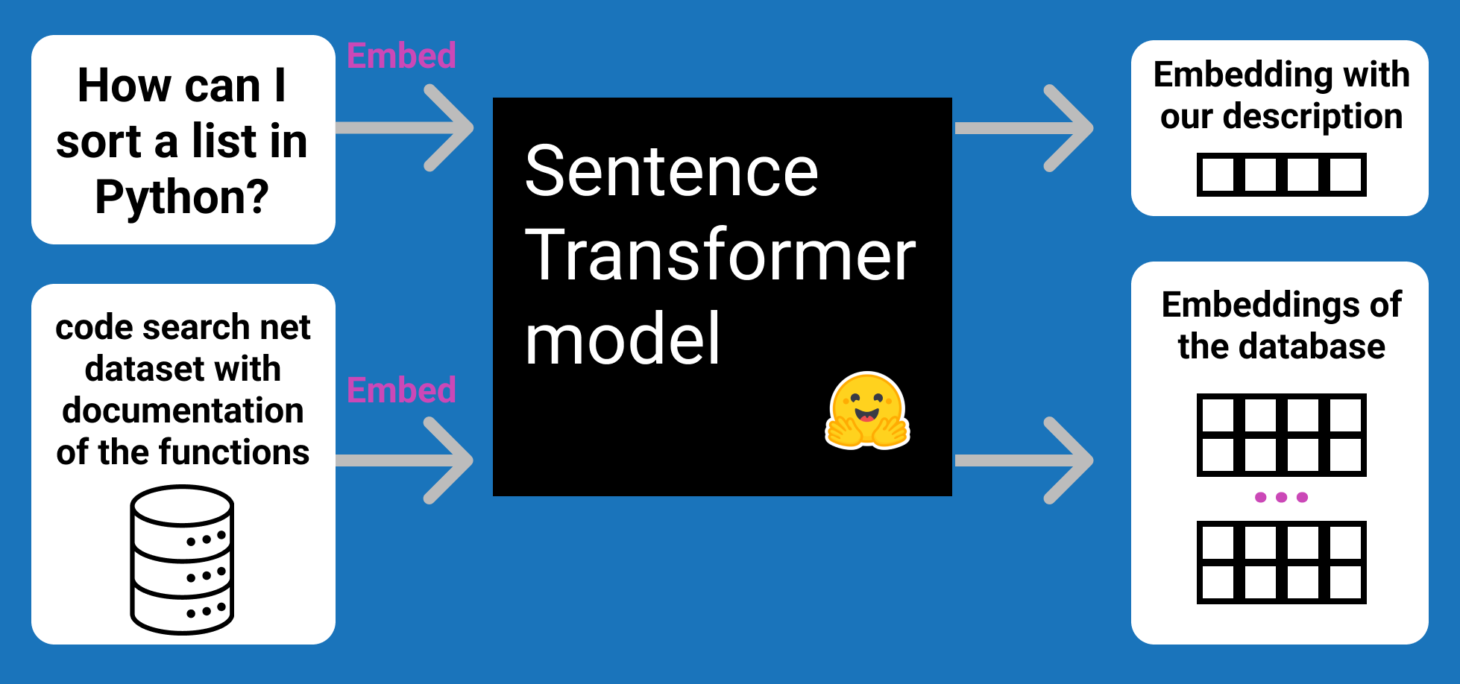

## Load the dataset

datasets is a library facilitated by Huggingface that allows us to load various formats of both our own datasets and datasets from their hub. In this case, we will load the dataset from the hub.

In [ ]:
#! pip install sentence-transformers datsets pandas torch huggingface-hub

In [26]:
from datasets import load_dataset
import pandas as pd
from sentence_transformers.util import semantic_search
import torch
from torch import cosine_similarity
from sentence_transformers import SentenceTransformer

In [2]:
dataset = load_dataset("code_search_net", "python")

In [23]:
print("------ TRAINING DATASET ------ \n")
print(dataset["train"][0])
print("------ docstring example ------ \n")
print(dataset["train"][0]["func_documentation_string"])

------ TRAINING DATASET ------ 

{'repository_name': 'proycon/pynlpl', 'func_path_in_repository': 'pynlpl/formats/folia.py', 'func_name': 'AbstractElement.addidsuffix', 'whole_func_string': 'def addidsuffix(self, idsuffix, recursive = True):\n        """Appends a suffix to this element\'s ID, and optionally to all child IDs as well. There is sually no need to call this directly, invoked implicitly by :meth:`copy`"""\n        if self.id: self.id += idsuffix\n        if recursive:\n            for e in self:\n                try:\n                    e.addidsuffix(idsuffix, recursive)\n                except Exception:\n                    pass', 'language': 'python', 'func_code_string': 'def addidsuffix(self, idsuffix, recursive = True):\n        """Appends a suffix to this element\'s ID, and optionally to all child IDs as well. There is sually no need to call this directly, invoked implicitly by :meth:`copy`"""\n        if self.id: self.id += idsuffix\n        if recursive:\n          

using pandas data manipulation methods, we will get the train data from the dataset to cosntruct a DataFrame, and then grab the text documentation of each entry stored in *func_documentation_string*

this will be used to construct the text corpus for the sentence transformer model

In [6]:
df = pd.DataFrame(dataset["train"])

text = df["func_documentation_string"].tolist()
print(text[:2])

["Appends a suffix to this element's ID, and optionally to all child IDs as well. There is sually no need to call this directly, invoked implicitly by :meth:`copy`", 'Correct all parent relations for elements within the scop. There is sually no need to call this directly, invoked implicitly by :meth:`copy`']


## Sentence Transformers


*all-mpnet-base-v2* is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

*all-mpnet-base-v2* project aims to train sentence embedding models on very large sentence level datasets using a self-supervised contrastive learning objective. it is based on pretrained *microsoft/mpnet-base* model and fine-tuned in on a **1B** sentence pairs dataset. using contrastive learning objective: given a sentence from the pair, the model should predict which out of a set of randomly sampled other sentences, was actually paired with it in the train dataset.

Let`s load the model using SentenceTransformer loader right from huggingface Directory

because of hardware limitations we will be embedding only the first 3000 entries of the dataset,feel free to adjust this number to your needs

In [8]:

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(text[:3000])
print(f"Embeddings dim:{len(embeddings[0])}")
print("---- Embedding Example ---- \n")
print(embeddings[0])


Embeddings dim:768
---- Embedding Example ---- 

[ 6.43047551e-03 -7.80999288e-02 -3.93975079e-02  1.59404695e-03
 -5.09597883e-02  4.14629504e-02  2.96745561e-02  3.67811043e-03
  1.79679866e-03 -4.64913575e-03 -4.63389196e-02 -3.38873803e-03
  3.15762833e-02  1.64989345e-02  3.08577549e-02 -6.12555945e-04
  3.68120037e-02 -2.75496468e-02 -3.66610400e-02 -3.38043533e-02
 -7.53396004e-02 -3.34190354e-02  1.07468572e-02  2.37753298e-02
  8.71260185e-04  2.15004608e-02 -1.53601468e-02  4.91480306e-02
 -2.99997907e-02 -8.08113813e-03 -1.71944033e-03  7.78612643e-02
 -1.30887460e-02 -9.43235960e-03  1.50362973e-06 -1.58559848e-02
  4.67198016e-03 -1.09851081e-02 -1.44632813e-02 -9.27730836e-03
 -3.45623456e-02  3.10864840e-02 -5.47174625e-02 -2.98714060e-02
  7.20429569e-02 -7.13652046e-03  1.59120355e-02  1.88554488e-02
 -4.22116427e-04 -4.04324718e-02 -1.32248725e-03  1.30404262e-02
 -1.14977276e-02 -1.36096776e-02  9.96051133e-02 -3.64808668e-03
  4.39689010e-02  4.36323471e-02  2.64314

we now have an in memory representation of our vectorial space and the embeddings. the *user_query* is embedded using the same transformer model and then cast both of them to torch float representations of the embeddings.

In [28]:
user_query = "add a suffix to an id"
query_embeddings = torch.from_numpy(model.encode(user_query)).to(torch.float)
corpus_embeddings = torch.from_numpy(embeddings).to(torch.float)

## Semantic Search

by default semantic_search uses cosine similarity as the score function, we can use any function that measures the distance between two vectors in a vector space and then normalize the scores to be between 0 and 1 to be taken as a score.

### Cosine Similarity
it is a relatively simple metric to understand and implement and it is also quite fast to compute, especially with the help of numpy. The cosine similarity is the cosine of the angle between two vectors that represent the embedding of two particular documents. The angle will be 0 if the documents are identical, making the cosine function to return 1. If the documents are dissimilar, the angle will be close to 90 degrees and the cosine function will return approximately 0.is a good way to compare documents of different lengths.

other metrics that can be used are:
- Euclidean Distance
- Dot product
- Manhattan Distance

In [30]:
hits = semantic_search(query_embeddings=query_embeddings, corpus_embeddings=corpus_embeddings, top_k=3)

print(hits)

[[{'corpus_id': 1836, 'score': 0.4663703143596649}, {'corpus_id': 0, 'score': 0.424063503742218}, {'corpus_id': 2270, 'score': 0.41767799854278564}]]


## Displaying the results

we get an Id that identifies the text corpus and a score of similarity between the query and such document.

using this Id and a positional index inside our DataFrame we can get the all the information about the document.

we will construct a new dataframe based on the results of the query.

In [22]:
results = pd.DataFrame(
             [df.iloc[hits[0][i]['corpus_id']] for i in range(len(hits[0]))]
             )

print("---- Functions ----")

for i in range(len(hits[0])):
    print("Score: {:.4f}".format(hits[0][i]['score']))
    print("Function: {}".format(results.iloc[i]['func_code_string']))
    print("repository Name: {}".format(results.iloc[i]['repository_name']))
    print("")

---- Functions ----
Score: 0.4664
Function: def get_attribute_name_id(attr):
    """
    Return the attribute name identifier
    """
    return attr.value.id if isinstance(attr.value, ast.Name) else None
repository Name: mschwager/cohesion

Score: 0.4241
Function: def addidsuffix(self, idsuffix, recursive = True):
        """Appends a suffix to this element's ID, and optionally to all child IDs as well. There is sually no need to call this directly, invoked implicitly by :meth:`copy`"""
        if self.id: self.id += idsuffix
        if recursive:
            for e in self:
                try:
                    e.addidsuffix(idsuffix, recursive)
                except Exception:
                    pass
repository Name: proycon/pynlpl

Score: 0.4177
Function: def get_parent_device(self):
        """Retreive parent device string id"""
        if not self.parent_instance_id:
            return ""
        dev_buffer_type = winapi.c_tchar * MAX_DEVICE_ID_LEN
        dev_buffer = dev_bu